In [ ]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

The console stream is logged into /root/sg_logs/console.log


[2023-06-14 07:01:42] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-14 07:01:52] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-14 07:01:52] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-14 07:01:52] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-14 07:01:52] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
from IPython.display import clear_output

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
from super_gradients.training import models

In [ ]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='car_final', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Q8Mgu1xguB8Jw2oFCZwI")
project = rf.workspace("mayank-tripathi-h4ov1").project("carz-ueyjb")
dataset = project.version(2).download("yolov5")



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to carz-2 in yolov5pytorch:: 100%|██████████| 1796/1796 [00:00<00:00, 7114.78it/s]


In [ ]:

dataset_params = {
    'data_dir':'/content/carz-2',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['licence']
}


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Caching annotations: 100%|██████████| 97/97 [00:00<00:00, 4665.15it/s]


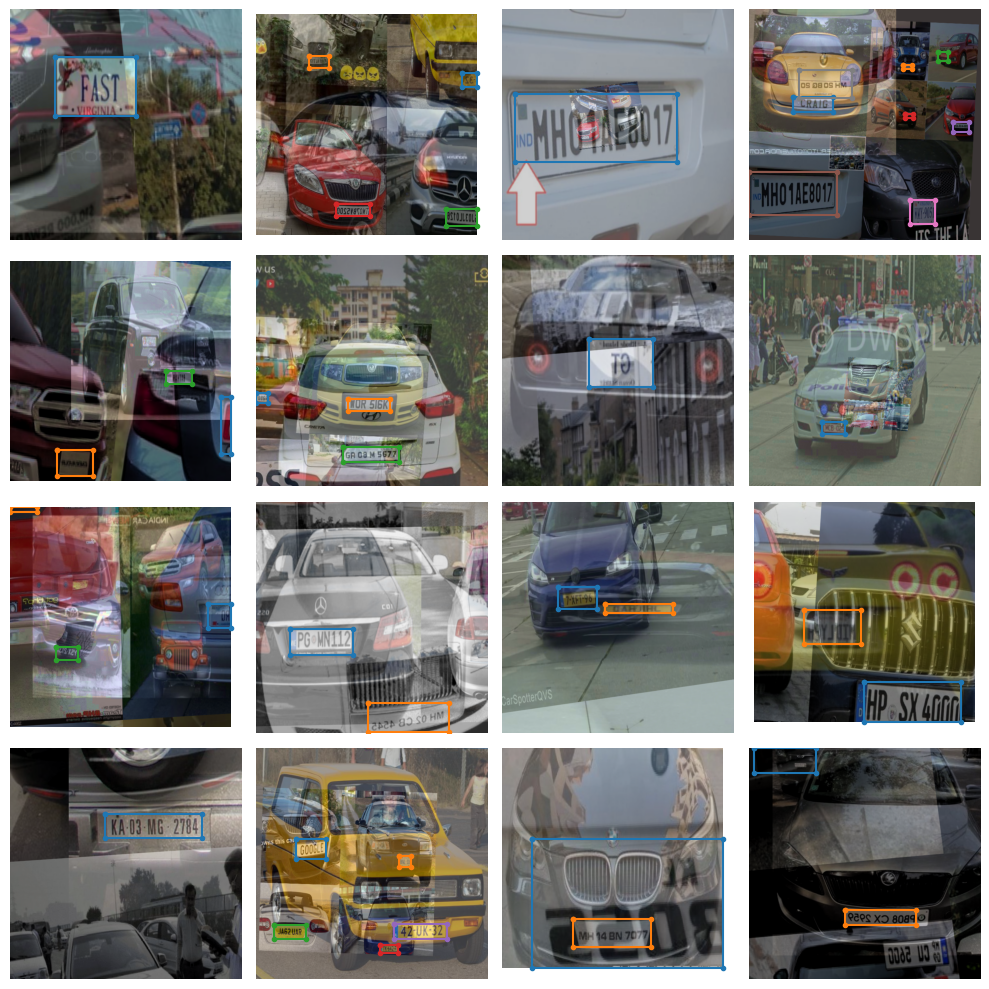

In [ ]:
train_data.dataset.plot()

In [ ]:
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-06-14 07:06:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

summary(model=model,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

In [ ]:
train_params = {
    # DISABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 30 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2023-06-14 07:08:06] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-06-14 07:08:10] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints/car_final/console_Jun14_07_08_11.txt


[2023-06-14 07:08:18] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 713        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         44         (len(train_loader))
    - Gradient updates per epoch:   44         (len(train_loader) / batch_accumulate)

[2023-06-14 07:08:18] INFO - sg_trainer.py - Started training for 30 epochs (0/29)

Validation epoch 0: 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.5044
│   ├── Ppyoloeloss/loss_cls = 2.0933
│   ├── Ppyoloeloss/loss_dfl = 1.4176
│   └── Ppyoloeloss/loss_iou = 0.2809
└── Validation
    ├── F1@0.50 = 0.0
    ├── Map@0.50 = 0.0
    ├── Ppyoloeloss/loss = 3.503
    ├── Ppyoloeloss/loss_cls = 2.1385
    ├── Ppyoloeloss/loss_dfl = 1.4764
    ├── Ppyoloeloss/loss_iou = 0.2505
    ├── Precision@0.50 = 0.0
    └── Recall@0.50 = 0.0



[2023-06-14 07:09:44] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:09:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 2.5227749574696645e-05
Validation epoch 1: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.2415
│   │   ├── Best until now = 3.5044 (↘ -1.263)
│   │   └── Epoch N-1      = 3.5044 (↘ -1.263)
│   ├── Ppyoloeloss/loss_cls = 1.1181
│   │   ├── Best until now = 2.0933 (↘ -0.9752)
│   │   └── Epoch N-1      = 2.0933 (↘ -0.9752)
│   ├── Ppyoloeloss/loss_dfl = 1.1577
│   │   ├── Best until now = 1.4176 (↘ -0.26)
│   │   └── Epoch N-1      = 1.4176 (↘ -0.26)
│   └── Ppyoloeloss/loss_iou = 0.2178
│       ├── Best until now = 0.2809 (↘ -0.0631)
│       └── Epoch N-1      = 0.2809 (↘ -0.0631)
└── Validation
    ├── F1@0.50 = 0.0075
    │   ├── Best until now = 0.0    (↗ 0.0075)
    │   └── Epoch N-1      = 0.0    (↗ 0.0075)
    ├── Map@0.50 = 0.6943
    │   ├── Best until now = 0.0    (↗ 0.6942)
    │   └── Epoch N-1      = 0.0    (↗ 0.6942)
    ├── Ppyoloeloss/loss = 3.0275
    │   ├── Best until now = 3.503  (↘ -0.4755)
    │   └── Epoch N-1      = 3.503  (↘ -0.4755)
    ├── Ppyoloeloss/loss_cls = 1.9669
    │   ├── Best unt

[2023-06-14 07:11:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:11:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6942616701126099
Validation epoch 2: 100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 2.0614
│   │   ├── Best until now = 2.2415 (↘ -0.1801)
│   │   └── Epoch N-1      = 2.2415 (↘ -0.1801)
│   ├── Ppyoloeloss/loss_cls = 0.947
│   │   ├── Best until now = 1.1181 (↘ -0.1711)
│   │   └── Epoch N-1      = 1.1181 (↘ -0.1711)
│   ├── Ppyoloeloss/loss_dfl = 1.1189
│   │   ├── Best until now = 1.1577 (↘ -0.0388)
│   │   └── Epoch N-1      = 1.1577 (↘ -0.0388)
│   └── Ppyoloeloss/loss_iou = 0.222
│       ├── Best until now = 0.2178 (↗ 0.0042)
│       └── Epoch N-1      = 0.2178 (↗ 0.0042)
└── Validation
    ├── F1@0.50 = 0.0314
    │   ├── Best until now = 0.0075 (↗ 0.024)
    │   └── Epoch N-1      = 0.0075 (↗ 0.024)
    ├── Map@0.50 = 0.7999
    │   ├── Best until now = 0.6943 (↗ 0.1056)
    │   └── Epoch N-1      = 0.6943 (↗ 0.1056)
    ├── Ppyoloeloss/loss = 2.0552
    │   ├── Best until now = 3.0275 (↘ -0.9724)
    │   └── Epoch N-1      = 3.0275 (↘ -0.9724)
    ├── Ppyoloeloss/loss_cls = 0.9489
    │   ├── Best unt

[2023-06-14 07:12:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:12:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7998688817024231
Validation epoch 3: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 2.0516
│   │   ├── Best until now = 2.0614 (↘ -0.0098)
│   │   └── Epoch N-1      = 2.0614 (↘ -0.0098)
│   ├── Ppyoloeloss/loss_cls = 0.9564
│   │   ├── Best until now = 0.947  (↗ 0.0094)
│   │   └── Epoch N-1      = 0.947  (↗ 0.0094)
│   ├── Ppyoloeloss/loss_dfl = 1.1057
│   │   ├── Best until now = 1.1189 (↘ -0.0132)
│   │   └── Epoch N-1      = 1.1189 (↘ -0.0132)
│   └── Ppyoloeloss/loss_iou = 0.2169
│       ├── Best until now = 0.2178 (↘ -0.0009)
│       └── Epoch N-1      = 0.222  (↘ -0.005)
└── Validation
    ├── F1@0.50 = 0.0145
    │   ├── Best until now = 0.0314 (↘ -0.0169)
    │   └── Epoch N-1      = 0.0314 (↘ -0.0169)
    ├── Map@0.50 = 0.4965
    │   ├── Best until now = 0.7999 (↘ -0.3034)
    │   └── Epoch N-1      = 0.7999 (↘ -0.3034)
    ├── Ppyoloeloss/loss = 3.357
    │   ├── Best until now = 2.0552 (↗ 1.3019)
    │   └── Epoch N-1      = 2.0552 (↗ 1.3019)
    ├── Ppyoloeloss/loss_cls = 2.2111
    │   ├── Best

Validation epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 2.006
│   │   ├── Best until now = 2.0516 (↘ -0.0455)
│   │   └── Epoch N-1      = 2.0516 (↘ -0.0455)
│   ├── Ppyoloeloss/loss_cls = 0.9234
│   │   ├── Best until now = 0.947  (↘ -0.0235)
│   │   └── Epoch N-1      = 0.9564 (↘ -0.0329)
│   ├── Ppyoloeloss/loss_dfl = 1.0862
│   │   ├── Best until now = 1.1057 (↘ -0.0195)
│   │   └── Epoch N-1      = 1.1057 (↘ -0.0195)
│   └── Ppyoloeloss/loss_iou = 0.2158
│       ├── Best until now = 0.2169 (↘ -0.0011)
│       └── Epoch N-1      = 0.2169 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.0487
    │   ├── Best until now = 0.0314 (↗ 0.0173)
    │   └── Epoch N-1      = 0.0145 (↗ 0.0342)
    ├── Map@0.50 = 0.8363
    │   ├── Best until now = 0.7999 (↗ 0.0365)
    │   └── Epoch N-1      = 0.4965 (↗ 0.3398)
    ├── Ppyoloeloss/loss = 2.0519
    │   ├── Best until now = 2.0552 (↘ -0.0032)
    │   └── Epoch N-1      = 3.357  (↘ -1.3051)
    ├── Ppyoloeloss/loss_cls = 0.9357
    │   ├── Bes

[2023-06-14 07:15:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:15:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8363236784934998
Validation epoch 5: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.9928
│   │   ├── Best until now = 2.006  (↘ -0.0132)
│   │   └── Epoch N-1      = 2.006  (↘ -0.0132)
│   ├── Ppyoloeloss/loss_cls = 0.9191
│   │   ├── Best until now = 0.9234 (↘ -0.0043)
│   │   └── Epoch N-1      = 0.9234 (↘ -0.0043)
│   ├── Ppyoloeloss/loss_dfl = 1.0817
│   │   ├── Best until now = 1.0862 (↘ -0.0045)
│   │   └── Epoch N-1      = 1.0862 (↘ -0.0045)
│   └── Ppyoloeloss/loss_iou = 0.2131
│       ├── Best until now = 0.2158 (↘ -0.0027)
│       └── Epoch N-1      = 0.2158 (↘ -0.0027)
└── Validation
    ├── F1@0.50 = 0.0362
    │   ├── Best until now = 0.0487 (↘ -0.0125)
    │   └── Epoch N-1      = 0.0487 (↘ -0.0125)
    ├── Map@0.50 = 0.8005
    │   ├── Best until now = 0.8363 (↘ -0.0358)
    │   └── Epoch N-1      = 0.8363 (↘ -0.0358)
    ├── Ppyoloeloss/loss = 2.1148
    │   ├── Best until now = 2.0519 (↗ 0.0629)
    │   └── Epoch N-1      = 2.0519 (↗ 0.0629)
    ├── Ppyoloeloss/loss_cls = 1.015
    │   ├── B

Validation epoch 6: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.9415
│   │   ├── Best until now = 1.9928 (↘ -0.0513)
│   │   └── Epoch N-1      = 1.9928 (↘ -0.0513)
│   ├── Ppyoloeloss/loss_cls = 0.8971
│   │   ├── Best until now = 0.9191 (↘ -0.0221)
│   │   └── Epoch N-1      = 0.9191 (↘ -0.0221)
│   ├── Ppyoloeloss/loss_dfl = 1.052
│   │   ├── Best until now = 1.0817 (↘ -0.0297)
│   │   └── Epoch N-1      = 1.0817 (↘ -0.0297)
│   └── Ppyoloeloss/loss_iou = 0.2074
│       ├── Best until now = 0.2131 (↘ -0.0057)
│       └── Epoch N-1      = 0.2131 (↘ -0.0057)
└── Validation
    ├── F1@0.50 = 0.0347
    │   ├── Best until now = 0.0487 (↘ -0.014)
    │   └── Epoch N-1      = 0.0362 (↘ -0.0014)
    ├── Map@0.50 = 0.8422
    │   ├── Best until now = 0.8363 (↗ 0.0059)
    │   └── Epoch N-1      = 0.8005 (↗ 0.0417)
    ├── Ppyoloeloss/loss = 2.1527
    │   ├── Best until now = 2.0519 (↗ 0.1008)
    │   └── Epoch N-1      = 2.1148 (↗ 0.0379)
    ├── Ppyoloeloss/loss_cls = 1.0751
    │   ├── Best

[2023-06-14 07:18:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:18:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8422349095344543
Validation epoch 7: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.9353
│   │   ├── Best until now = 1.9415 (↘ -0.0063)
│   │   └── Epoch N-1      = 1.9415 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_cls = 0.88
│   │   ├── Best until now = 0.8971 (↘ -0.0171)
│   │   └── Epoch N-1      = 0.8971 (↘ -0.0171)
│   ├── Ppyoloeloss/loss_dfl = 1.067
│   │   ├── Best until now = 1.052  (↗ 0.015)
│   │   └── Epoch N-1      = 1.052  (↗ 0.015)
│   └── Ppyoloeloss/loss_iou = 0.2087
│       ├── Best until now = 0.2074 (↗ 0.0013)
│       └── Epoch N-1      = 0.2074 (↗ 0.0013)
└── Validation
    ├── F1@0.50 = 0.175
    │   ├── Best until now = 0.0487 (↗ 0.1263)
    │   └── Epoch N-1      = 0.0347 (↗ 0.1403)
    ├── Map@0.50 = 0.9159
    │   ├── Best until now = 0.8422 (↗ 0.0737)
    │   └── Epoch N-1      = 0.8422 (↗ 0.0737)
    ├── Ppyoloeloss/loss = 1.8545
    │   ├── Best until now = 2.0519 (↘ -0.1974)
    │   └── Epoch N-1      = 2.1527 (↘ -0.2982)
    ├── Ppyoloeloss/loss_cls = 0.826
    │   ├── Best until no

[2023-06-14 07:20:54] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:20:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9159477949142456
Validation epoch 8: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.9108
│   │   ├── Best until now = 1.9353 (↘ -0.0244)
│   │   └── Epoch N-1      = 1.9353 (↘ -0.0244)
│   ├── Ppyoloeloss/loss_cls = 0.8669
│   │   ├── Best until now = 0.88   (↘ -0.0131)
│   │   └── Epoch N-1      = 0.88   (↘ -0.0131)
│   ├── Ppyoloeloss/loss_dfl = 1.0597
│   │   ├── Best until now = 1.052  (↗ 0.0078)
│   │   └── Epoch N-1      = 1.067  (↘ -0.0072)
│   └── Ppyoloeloss/loss_iou = 0.2056
│       ├── Best until now = 0.2074 (↘ -0.0017)
│       └── Epoch N-1      = 0.2087 (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.1141
    │   ├── Best until now = 0.175  (↘ -0.0609)
    │   └── Epoch N-1      = 0.175  (↘ -0.0609)
    ├── Map@0.50 = 0.8949
    │   ├── Best until now = 0.9159 (↘ -0.0211)
    │   └── Epoch N-1      = 0.9159 (↘ -0.0211)
    ├── Ppyoloeloss/loss = 1.8748
    │   ├── Best until now = 1.8545 (↗ 0.0203)
    │   └── Epoch N-1      = 1.8545 (↗ 0.0203)
    ├── Ppyoloeloss/loss_cls = 0.8319
    │   ├── B

Validation epoch 9: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.902
│   │   ├── Best until now = 1.9108 (↘ -0.0088)
│   │   └── Epoch N-1      = 1.9108 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_cls = 0.873
│   │   ├── Best until now = 0.8669 (↗ 0.0061)
│   │   └── Epoch N-1      = 0.8669 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 1.0458
│   │   ├── Best until now = 1.052  (↘ -0.0061)
│   │   └── Epoch N-1      = 1.0597 (↘ -0.0139)
│   └── Ppyoloeloss/loss_iou = 0.2024
│       ├── Best until now = 0.2056 (↘ -0.0032)
│       └── Epoch N-1      = 0.2056 (↘ -0.0032)
└── Validation
    ├── F1@0.50 = 0.0458
    │   ├── Best until now = 0.175  (↘ -0.1292)
    │   └── Epoch N-1      = 0.1141 (↘ -0.0683)
    ├── Map@0.50 = 0.8308
    │   ├── Best until now = 0.9159 (↘ -0.0851)
    │   └── Epoch N-1      = 0.8949 (↘ -0.064)
    ├── Ppyoloeloss/loss = 1.9801
    │   ├── Best until now = 1.8545 (↗ 0.1257)
    │   └── Epoch N-1      = 1.8748 (↗ 0.1053)
    ├── Ppyoloeloss/loss_cls = 0.9253
    │   ├── Best 

Validation epoch 10: 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.8453
│   │   ├── Best until now = 1.902  (↘ -0.0567)
│   │   └── Epoch N-1      = 1.902  (↘ -0.0567)
│   ├── Ppyoloeloss/loss_cls = 0.8459
│   │   ├── Best until now = 0.8669 (↘ -0.021)
│   │   └── Epoch N-1      = 0.873  (↘ -0.0271)
│   ├── Ppyoloeloss/loss_dfl = 1.008
│   │   ├── Best until now = 1.0458 (↘ -0.0379)
│   │   └── Epoch N-1      = 1.0458 (↘ -0.0379)
│   └── Ppyoloeloss/loss_iou = 0.1982
│       ├── Best until now = 0.2024 (↘ -0.0043)
│       └── Epoch N-1      = 0.2024 (↘ -0.0043)
└── Validation
    ├── F1@0.50 = 0.0804
    │   ├── Best until now = 0.175  (↘ -0.0947)
    │   └── Epoch N-1      = 0.0458 (↗ 0.0346)
    ├── Map@0.50 = 0.9068
    │   ├── Best until now = 0.9159 (↘ -0.0091)
    │   └── Epoch N-1      = 0.8308 (↗ 0.076)
    ├── Ppyoloeloss/loss = 1.8903
    │   ├── Best until now = 1.8545 (↗ 0.0358)
    │   └── Epoch N-1      = 1.9801 (↘ -0.0898)
    ├── Ppyoloeloss/loss_cls = 0.8731
    │   ├── Bes

Validation epoch 11: 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.8438
│   │   ├── Best until now = 1.8453 (↘ -0.0015)
│   │   └── Epoch N-1      = 1.8453 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_cls = 0.8331
│   │   ├── Best until now = 0.8459 (↘ -0.0127)
│   │   └── Epoch N-1      = 0.8459 (↘ -0.0127)
│   ├── Ppyoloeloss/loss_dfl = 1.023
│   │   ├── Best until now = 1.008  (↗ 0.015)
│   │   └── Epoch N-1      = 1.008  (↗ 0.015)
│   └── Ppyoloeloss/loss_iou = 0.1997
│       ├── Best until now = 0.1982 (↗ 0.0015)
│       └── Epoch N-1      = 0.1982 (↗ 0.0015)
└── Validation
    ├── F1@0.50 = 0.1489
    │   ├── Best until now = 0.175  (↘ -0.0261)
    │   └── Epoch N-1      = 0.0804 (↗ 0.0685)
    ├── Map@0.50 = 0.865
    │   ├── Best until now = 0.9159 (↘ -0.0509)
    │   └── Epoch N-1      = 0.9068 (↘ -0.0418)
    ├── Ppyoloeloss/loss = 1.8319
    │   ├── Best until now = 1.8545 (↘ -0.0226)
    │   └── Epoch N-1      = 1.8903 (↘ -0.0584)
    ├── Ppyoloeloss/loss_cls = 0.8046
    │   ├── Best u

Validation epoch 12: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.8383
│   │   ├── Best until now = 1.8438 (↘ -0.0055)
│   │   └── Epoch N-1      = 1.8438 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_cls = 0.8351
│   │   ├── Best until now = 0.8331 (↗ 0.002)
│   │   └── Epoch N-1      = 0.8331 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 1.0182
│   │   ├── Best until now = 1.008  (↗ 0.0102)
│   │   └── Epoch N-1      = 1.023  (↘ -0.0048)
│   └── Ppyoloeloss/loss_iou = 0.1977
│       ├── Best until now = 0.1982 (↘ -0.0005)
│       └── Epoch N-1      = 0.1997 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.1215
    │   ├── Best until now = 0.175  (↘ -0.0535)
    │   └── Epoch N-1      = 0.1489 (↘ -0.0274)
    ├── Map@0.50 = 0.9377
    │   ├── Best until now = 0.9159 (↗ 0.0217)
    │   └── Epoch N-1      = 0.865  (↗ 0.0727)
    ├── Ppyoloeloss/loss = 1.8133
    │   ├── Best until now = 1.8319 (↘ -0.0185)
    │   └── Epoch N-1      = 1.8319 (↘ -0.0185)
    ├── Ppyoloeloss/loss_cls = 0.7935
    │   ├── Best 

[2023-06-14 07:34:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:34:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9376899003982544
Validation epoch 13: 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.8243
│   │   ├── Best until now = 1.8383 (↘ -0.0141)
│   │   └── Epoch N-1      = 1.8383 (↘ -0.0141)
│   ├── Ppyoloeloss/loss_cls = 0.8388
│   │   ├── Best until now = 0.8331 (↗ 0.0057)
│   │   └── Epoch N-1      = 0.8351 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.9974
│   │   ├── Best until now = 1.008  (↘ -0.0106)
│   │   └── Epoch N-1      = 1.0182 (↘ -0.0208)
│   └── Ppyoloeloss/loss_iou = 0.1947
│       ├── Best until now = 0.1977 (↘ -0.003)
│       └── Epoch N-1      = 0.1977 (↘ -0.003)
└── Validation
    ├── F1@0.50 = 0.0713
    │   ├── Best until now = 0.175  (↘ -0.1037)
    │   └── Epoch N-1      = 0.1215 (↘ -0.0502)
    ├── Map@0.50 = 0.932
    │   ├── Best until now = 0.9377 (↘ -0.0057)
    │   └── Epoch N-1      = 0.9377 (↘ -0.0057)
    ├── Ppyoloeloss/loss = 1.8738
    │   ├── Best until now = 1.8133 (↗ 0.0605)
    │   └── Epoch N-1      = 1.8133 (↗ 0.0605)
    ├── Ppyoloeloss/loss_cls = 0.8501
    │   ├── Best

Validation epoch 14: 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.8554
│   │   ├── Best until now = 1.8243 (↗ 0.0312)
│   │   └── Epoch N-1      = 1.8243 (↗ 0.0312)
│   ├── Ppyoloeloss/loss_cls = 0.861
│   │   ├── Best until now = 0.8331 (↗ 0.0279)
│   │   └── Epoch N-1      = 0.8388 (↗ 0.0222)
│   ├── Ppyoloeloss/loss_dfl = 0.9988
│   │   ├── Best until now = 0.9974 (↗ 0.0014)
│   │   └── Epoch N-1      = 0.9974 (↗ 0.0014)
│   └── Ppyoloeloss/loss_iou = 0.198
│       ├── Best until now = 0.1947 (↗ 0.0033)
│       └── Epoch N-1      = 0.1947 (↗ 0.0033)
└── Validation
    ├── F1@0.50 = 0.0797
    │   ├── Best until now = 0.175  (↘ -0.0953)
    │   └── Epoch N-1      = 0.0713 (↗ 0.0083)
    ├── Map@0.50 = 0.9488
    │   ├── Best until now = 0.9377 (↗ 0.0111)
    │   └── Epoch N-1      = 0.932  (↗ 0.0168)
    ├── Ppyoloeloss/loss = 1.8744
    │   ├── Best until now = 1.8133 (↗ 0.061)
    │   └── Epoch N-1      = 1.8738 (↗ 0.0005)
    ├── Ppyoloeloss/loss_cls = 0.8376
    │   ├── Best until no

[2023-06-14 07:40:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:40:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9488115310668945
Validation epoch 15: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.833
│   │   ├── Best until now = 1.8243 (↗ 0.0087)
│   │   └── Epoch N-1      = 1.8554 (↘ -0.0224)
│   ├── Ppyoloeloss/loss_cls = 0.8366
│   │   ├── Best until now = 0.8331 (↗ 0.0035)
│   │   └── Epoch N-1      = 0.861  (↘ -0.0244)
│   ├── Ppyoloeloss/loss_dfl = 1.0074
│   │   ├── Best until now = 0.9974 (↗ 0.01)
│   │   └── Epoch N-1      = 0.9988 (↗ 0.0086)
│   └── Ppyoloeloss/loss_iou = 0.1971
│       ├── Best until now = 0.1947 (↗ 0.0024)
│       └── Epoch N-1      = 0.198  (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.1123
    │   ├── Best until now = 0.175  (↘ -0.0627)
    │   └── Epoch N-1      = 0.0797 (↗ 0.0326)
    ├── Map@0.50 = 0.9356
    │   ├── Best until now = 0.9488 (↘ -0.0132)
    │   └── Epoch N-1      = 0.9488 (↘ -0.0132)
    ├── Ppyoloeloss/loss = 1.8668
    │   ├── Best until now = 1.8133 (↗ 0.0534)
    │   └── Epoch N-1      = 1.8744 (↘ -0.0076)
    ├── Ppyoloeloss/loss_cls = 0.8197
    │   ├── Best un

Validation epoch 16: 100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.789
│   │   ├── Best until now = 1.8243 (↘ -0.0352)
│   │   └── Epoch N-1      = 1.833  (↘ -0.044)
│   ├── Ppyoloeloss/loss_cls = 0.822
│   │   ├── Best until now = 0.8331 (↘ -0.0111)
│   │   └── Epoch N-1      = 0.8366 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.9858
│   │   ├── Best until now = 0.9974 (↘ -0.0116)
│   │   └── Epoch N-1      = 1.0074 (↘ -0.0216)
│   └── Ppyoloeloss/loss_iou = 0.1897
│       ├── Best until now = 0.1947 (↘ -0.0051)
│       └── Epoch N-1      = 0.1971 (↘ -0.0074)
└── Validation
    ├── F1@0.50 = 0.1123
    │   ├── Best until now = 0.175  (↘ -0.0627)
    │   └── Epoch N-1      = 0.1123 (= 0.0)
    ├── Map@0.50 = 0.9476
    │   ├── Best until now = 0.9488 (↘ -0.0012)
    │   └── Epoch N-1      = 0.9356 (↗ 0.012)
    ├── Ppyoloeloss/loss = 1.7897
    │   ├── Best until now = 1.8133 (↘ -0.0237)
    │   └── Epoch N-1      = 1.8668 (↘ -0.0771)
    ├── Ppyoloeloss/loss_cls = 0.8087
    │   ├── Best u

Validation epoch 17: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.7569
│   │   ├── Best until now = 1.789  (↘ -0.0321)
│   │   └── Epoch N-1      = 1.789  (↘ -0.0321)
│   ├── Ppyoloeloss/loss_cls = 0.811
│   │   ├── Best until now = 0.822  (↘ -0.011)
│   │   └── Epoch N-1      = 0.822  (↘ -0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.966
│   │   ├── Best until now = 0.9858 (↘ -0.0198)
│   │   └── Epoch N-1      = 0.9858 (↘ -0.0198)
│   └── Ppyoloeloss/loss_iou = 0.1852
│       ├── Best until now = 0.1897 (↘ -0.0045)
│       └── Epoch N-1      = 0.1897 (↘ -0.0045)
└── Validation
    ├── F1@0.50 = 0.1255
    │   ├── Best until now = 0.175  (↘ -0.0495)
    │   └── Epoch N-1      = 0.1123 (↗ 0.0132)
    ├── Map@0.50 = 0.9443
    │   ├── Best until now = 0.9488 (↘ -0.0045)
    │   └── Epoch N-1      = 0.9476 (↘ -0.0033)
    ├── Ppyoloeloss/loss = 1.8074
    │   ├── Best until now = 1.7897 (↗ 0.0177)
    │   └── Epoch N-1      = 1.7897 (↗ 0.0177)
    ├── Ppyoloeloss/loss_cls = 0.8083
    │   ├── Best

Validation epoch 18: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.7501
│   │   ├── Best until now = 1.7569 (↘ -0.0068)
│   │   └── Epoch N-1      = 1.7569 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_cls = 0.7995
│   │   ├── Best until now = 0.811  (↘ -0.0115)
│   │   └── Epoch N-1      = 0.811  (↘ -0.0115)
│   ├── Ppyoloeloss/loss_dfl = 0.9736
│   │   ├── Best until now = 0.966  (↗ 0.0076)
│   │   └── Epoch N-1      = 0.966  (↗ 0.0076)
│   └── Ppyoloeloss/loss_iou = 0.1855
│       ├── Best until now = 0.1852 (↗ 0.0003)
│       └── Epoch N-1      = 0.1852 (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.1508
    │   ├── Best until now = 0.175  (↘ -0.0242)
    │   └── Epoch N-1      = 0.1255 (↗ 0.0253)
    ├── Map@0.50 = 0.9553
    │   ├── Best until now = 0.9488 (↗ 0.0065)
    │   └── Epoch N-1      = 0.9443 (↗ 0.011)
    ├── Ppyoloeloss/loss = 1.7346
    │   ├── Best until now = 1.7897 (↘ -0.0551)
    │   └── Epoch N-1      = 1.8074 (↘ -0.0728)
    ├── Ppyoloeloss/loss_cls = 0.7514
    │   ├── Best 

[2023-06-14 07:51:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:51:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9552903771400452
Validation epoch 19: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.7504
│   │   ├── Best until now = 1.7501 (↗ 0.0002)
│   │   └── Epoch N-1      = 1.7501 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_cls = 0.7997
│   │   ├── Best until now = 0.7995 (↗ 0.0002)
│   │   └── Epoch N-1      = 0.7995 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.9769
│   │   ├── Best until now = 0.966  (↗ 0.0108)
│   │   └── Epoch N-1      = 0.9736 (↗ 0.0032)
│   └── Ppyoloeloss/loss_iou = 0.1849
│       ├── Best until now = 0.1852 (↘ -0.0003)
│       └── Epoch N-1      = 0.1855 (↘ -0.0006)
└── Validation
    ├── F1@0.50 = 0.1508
    │   ├── Best until now = 0.175  (↘ -0.0242)
    │   └── Epoch N-1      = 0.1508 (↘ -0.0)
    ├── Map@0.50 = 0.9521
    │   ├── Best until now = 0.9553 (↘ -0.0032)
    │   └── Epoch N-1      = 0.9553 (↘ -0.0032)
    ├── Ppyoloeloss/loss = 1.7427
    │   ├── Best until now = 1.7346 (↗ 0.0081)
    │   └── Epoch N-1      = 1.7346 (↗ 0.0081)
    ├── Ppyoloeloss/loss_cls = 0.7455
    │   ├── Best unt

Validation epoch 20: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.7353
│   │   ├── Best until now = 1.7501 (↘ -0.0148)
│   │   └── Epoch N-1      = 1.7504 (↘ -0.0151)
│   ├── Ppyoloeloss/loss_cls = 0.7929
│   │   ├── Best until now = 0.7995 (↘ -0.0066)
│   │   └── Epoch N-1      = 0.7997 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.9634
│   │   ├── Best until now = 0.966  (↘ -0.0027)
│   │   └── Epoch N-1      = 0.9769 (↘ -0.0135)
│   └── Ppyoloeloss/loss_iou = 0.1843
│       ├── Best until now = 0.1849 (↘ -0.0006)
│       └── Epoch N-1      = 0.1849 (↘ -0.0006)
└── Validation
    ├── F1@0.50 = 0.1197
    │   ├── Best until now = 0.175  (↘ -0.0553)
    │   └── Epoch N-1      = 0.1508 (↘ -0.0311)
    ├── Map@0.50 = 0.9667
    │   ├── Best until now = 0.9553 (↗ 0.0114)
    │   └── Epoch N-1      = 0.9521 (↗ 0.0146)
    ├── Ppyoloeloss/loss = 1.7445
    │   ├── Best until now = 1.7346 (↗ 0.0099)
    │   └── Epoch N-1      = 1.7427 (↗ 0.0018)
    ├── Ppyoloeloss/loss_cls = 0.7734
    │   ├── B

[2023-06-14 07:57:15] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 07:57:15] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9666703343391418
Validation epoch 21: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


SUMMARY OF EPOCH 21
├── Training
│   ├── Ppyoloeloss/loss = 1.7089
│   │   ├── Best until now = 1.7353 (↘ -0.0264)
│   │   └── Epoch N-1      = 1.7353 (↘ -0.0264)
│   ├── Ppyoloeloss/loss_cls = 0.7922
│   │   ├── Best until now = 0.7929 (↘ -0.0007)
│   │   └── Epoch N-1      = 0.7929 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.9455
│   │   ├── Best until now = 0.9634 (↘ -0.0179)
│   │   └── Epoch N-1      = 0.9634 (↘ -0.0179)
│   └── Ppyoloeloss/loss_iou = 0.1776
│       ├── Best until now = 0.1843 (↘ -0.0067)
│       └── Epoch N-1      = 0.1843 (↘ -0.0067)
└── Validation
    ├── F1@0.50 = 0.1918
    │   ├── Best until now = 0.175  (↗ 0.0168)
    │   └── Epoch N-1      = 0.1197 (↗ 0.0721)
    ├── Map@0.50 = 0.9608
    │   ├── Best until now = 0.9667 (↘ -0.0059)
    │   └── Epoch N-1      = 0.9667 (↘ -0.0059)
    ├── Ppyoloeloss/loss = 1.7298
    │   ├── Best until now = 1.7346 (↘ -0.0048)
    │   └── Epoch N-1      = 1.7445 (↘ -0.0147)
    ├── Ppyoloeloss/loss_cls = 0.756
    │   ├── 

Validation epoch 22: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


SUMMARY OF EPOCH 22
├── Training
│   ├── Ppyoloeloss/loss = 1.7084
│   │   ├── Best until now = 1.7089 (↘ -0.0005)
│   │   └── Epoch N-1      = 1.7089 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_cls = 0.7818
│   │   ├── Best until now = 0.7922 (↘ -0.0104)
│   │   └── Epoch N-1      = 0.7922 (↘ -0.0104)
│   ├── Ppyoloeloss/loss_dfl = 0.9568
│   │   ├── Best until now = 0.9455 (↗ 0.0113)
│   │   └── Epoch N-1      = 0.9455 (↗ 0.0113)
│   └── Ppyoloeloss/loss_iou = 0.1793
│       ├── Best until now = 0.1776 (↗ 0.0017)
│       └── Epoch N-1      = 0.1776 (↗ 0.0017)
└── Validation
    ├── F1@0.50 = 0.1776
    │   ├── Best until now = 0.1918 (↘ -0.0142)
    │   └── Epoch N-1      = 0.1918 (↘ -0.0142)
    ├── Map@0.50 = 0.9731
    │   ├── Best until now = 0.9667 (↗ 0.0064)
    │   └── Epoch N-1      = 0.9608 (↗ 0.0123)
    ├── Ppyoloeloss/loss = 1.7275
    │   ├── Best until now = 1.7298 (↘ -0.0023)
    │   └── Epoch N-1      = 1.7298 (↘ -0.0023)
    ├── Ppyoloeloss/loss_cls = 0.7443
    │   ├── Bes

[2023-06-14 08:02:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 08:02:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9730930328369141
Validation epoch 23: 100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


SUMMARY OF EPOCH 23
├── Training
│   ├── Ppyoloeloss/loss = 1.6801
│   │   ├── Best until now = 1.7084 (↘ -0.0283)
│   │   └── Epoch N-1      = 1.7084 (↘ -0.0283)
│   ├── Ppyoloeloss/loss_cls = 0.7722
│   │   ├── Best until now = 0.7818 (↘ -0.0096)
│   │   └── Epoch N-1      = 0.7818 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.9412
│   │   ├── Best until now = 0.9455 (↘ -0.0043)
│   │   └── Epoch N-1      = 0.9568 (↘ -0.0156)
│   └── Ppyoloeloss/loss_iou = 0.1749
│       ├── Best until now = 0.1776 (↘ -0.0027)
│       └── Epoch N-1      = 0.1793 (↘ -0.0044)
└── Validation
    ├── F1@0.50 = 0.1888
    │   ├── Best until now = 0.1918 (↘ -0.0031)
    │   └── Epoch N-1      = 0.1776 (↗ 0.0111)
    ├── Map@0.50 = 0.9794
    │   ├── Best until now = 0.9731 (↗ 0.0063)
    │   └── Epoch N-1      = 0.9731 (↗ 0.0063)
    ├── Ppyoloeloss/loss = 1.7207
    │   ├── Best until now = 1.7275 (↘ -0.0068)
    │   └── Epoch N-1      = 1.7275 (↘ -0.0068)
    ├── Ppyoloeloss/loss_cls = 0.7514
    │   ├── 

[2023-06-14 08:05:25] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 08:05:25] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9794338941574097
Validation epoch 24: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]


SUMMARY OF EPOCH 24
├── Training
│   ├── Ppyoloeloss/loss = 1.658
│   │   ├── Best until now = 1.6801 (↘ -0.0221)
│   │   └── Epoch N-1      = 1.6801 (↘ -0.0221)
│   ├── Ppyoloeloss/loss_cls = 0.7545
│   │   ├── Best until now = 0.7722 (↘ -0.0177)
│   │   └── Epoch N-1      = 0.7722 (↘ -0.0177)
│   ├── Ppyoloeloss/loss_dfl = 0.9203
│   │   ├── Best until now = 0.9412 (↘ -0.021)
│   │   └── Epoch N-1      = 0.9412 (↘ -0.021)
│   └── Ppyoloeloss/loss_iou = 0.1774
│       ├── Best until now = 0.1749 (↗ 0.0024)
│       └── Epoch N-1      = 0.1749 (↗ 0.0024)
└── Validation
    ├── F1@0.50 = 0.1605
    │   ├── Best until now = 0.1918 (↘ -0.0313)
    │   └── Epoch N-1      = 0.1888 (↘ -0.0283)
    ├── Map@0.50 = 0.9558
    │   ├── Best until now = 0.9794 (↘ -0.0236)
    │   └── Epoch N-1      = 0.9794 (↘ -0.0236)
    ├── Ppyoloeloss/loss = 1.7489
    │   ├── Best until now = 1.7207 (↗ 0.0281)
    │   └── Epoch N-1      = 1.7207 (↗ 0.0281)
    ├── Ppyoloeloss/loss_cls = 0.7703
    │   ├── Best

Validation epoch 25: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]


SUMMARY OF EPOCH 25
├── Training
│   ├── Ppyoloeloss/loss = 1.6572
│   │   ├── Best until now = 1.658  (↘ -0.0008)
│   │   └── Epoch N-1      = 1.658  (↘ -0.0008)
│   ├── Ppyoloeloss/loss_cls = 0.7568
│   │   ├── Best until now = 0.7545 (↗ 0.0023)
│   │   └── Epoch N-1      = 0.7545 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.9295
│   │   ├── Best until now = 0.9203 (↗ 0.0092)
│   │   └── Epoch N-1      = 0.9203 (↗ 0.0092)
│   └── Ppyoloeloss/loss_iou = 0.1743
│       ├── Best until now = 0.1749 (↘ -0.0006)
│       └── Epoch N-1      = 0.1774 (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.2333
    │   ├── Best until now = 0.1918 (↗ 0.0415)
    │   └── Epoch N-1      = 0.1605 (↗ 0.0728)
    ├── Map@0.50 = 0.951
    │   ├── Best until now = 0.9794 (↘ -0.0284)
    │   └── Epoch N-1      = 0.9558 (↘ -0.0048)
    ├── Ppyoloeloss/loss = 1.6993
    │   ├── Best until now = 1.7207 (↘ -0.0214)
    │   └── Epoch N-1      = 1.7489 (↘ -0.0496)
    ├── Ppyoloeloss/loss_cls = 0.7257
    │   ├── Best

Validation epoch 26: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


SUMMARY OF EPOCH 26
├── Training
│   ├── Ppyoloeloss/loss = 1.6542
│   │   ├── Best until now = 1.6572 (↘ -0.003)
│   │   └── Epoch N-1      = 1.6572 (↘ -0.003)
│   ├── Ppyoloeloss/loss_cls = 0.7539
│   │   ├── Best until now = 0.7545 (↘ -0.0006)
│   │   └── Epoch N-1      = 0.7568 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.9287
│   │   ├── Best until now = 0.9203 (↗ 0.0084)
│   │   └── Epoch N-1      = 0.9295 (↘ -0.0008)
│   └── Ppyoloeloss/loss_iou = 0.1744
│       ├── Best until now = 0.1743 (↗ 1e-04)
│       └── Epoch N-1      = 0.1743 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.2127
    │   ├── Best until now = 0.2333 (↘ -0.0206)
    │   └── Epoch N-1      = 0.2333 (↘ -0.0206)
    ├── Map@0.50 = 0.9828
    │   ├── Best until now = 0.9794 (↗ 0.0033)
    │   └── Epoch N-1      = 0.951  (↗ 0.0317)
    ├── Ppyoloeloss/loss = 1.708
    │   ├── Best until now = 1.6993 (↗ 0.0087)
    │   └── Epoch N-1      = 1.6993 (↗ 0.0087)
    ├── Ppyoloeloss/loss_cls = 0.7321
    │   ├── Best unti

[2023-06-14 08:13:08] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/car_final/ckpt_best.pth
[2023-06-14 08:13:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.982758641242981
Validation epoch 27: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


SUMMARY OF EPOCH 27
├── Training
│   ├── Ppyoloeloss/loss = 1.6215
│   │   ├── Best until now = 1.6542 (↘ -0.0327)
│   │   └── Epoch N-1      = 1.6542 (↘ -0.0327)
│   ├── Ppyoloeloss/loss_cls = 0.7344
│   │   ├── Best until now = 0.7539 (↘ -0.0195)
│   │   └── Epoch N-1      = 0.7539 (↘ -0.0195)
│   ├── Ppyoloeloss/loss_dfl = 0.9167
│   │   ├── Best until now = 0.9203 (↘ -0.0036)
│   │   └── Epoch N-1      = 0.9287 (↘ -0.012)
│   └── Ppyoloeloss/loss_iou = 0.1715
│       ├── Best until now = 0.1743 (↘ -0.0028)
│       └── Epoch N-1      = 0.1744 (↘ -0.0029)
└── Validation
    ├── F1@0.50 = 0.1976
    │   ├── Best until now = 0.2333 (↘ -0.0357)
    │   └── Epoch N-1      = 0.2127 (↘ -0.0151)
    ├── Map@0.50 = 0.9795
    │   ├── Best until now = 0.9828 (↘ -0.0032)
    │   └── Epoch N-1      = 0.9828 (↘ -0.0032)
    ├── Ppyoloeloss/loss = 1.694
    │   ├── Best until now = 1.6993 (↘ -0.0053)
    │   └── Epoch N-1      = 1.708  (↘ -0.014)
    ├── Ppyoloeloss/loss_cls = 0.7351
    │   ├── 

Validation epoch 28: 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


SUMMARY OF EPOCH 28
├── Training
│   ├── Ppyoloeloss/loss = 1.6161
│   │   ├── Best until now = 1.6215 (↘ -0.0054)
│   │   └── Epoch N-1      = 1.6215 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_cls = 0.7379
│   │   ├── Best until now = 0.7344 (↗ 0.0034)
│   │   └── Epoch N-1      = 0.7344 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.9142
│   │   ├── Best until now = 0.9167 (↘ -0.0025)
│   │   └── Epoch N-1      = 0.9167 (↘ -0.0025)
│   └── Ppyoloeloss/loss_iou = 0.1684
│       ├── Best until now = 0.1715 (↘ -0.003)
│       └── Epoch N-1      = 0.1715 (↘ -0.003)
└── Validation
    ├── F1@0.50 = 0.1846
    │   ├── Best until now = 0.2333 (↘ -0.0486)
    │   └── Epoch N-1      = 0.1976 (↘ -0.0129)
    ├── Map@0.50 = 0.9808
    │   ├── Best until now = 0.9828 (↘ -0.002)
    │   └── Epoch N-1      = 0.9795 (↗ 0.0012)
    ├── Ppyoloeloss/loss = 1.7061
    │   ├── Best until now = 1.694  (↗ 0.0121)
    │   └── Epoch N-1      = 1.694  (↗ 0.0121)
    ├── Ppyoloeloss/loss_cls = 0.731
    │   ├── Best u

Validation epoch 29: 100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


SUMMARY OF EPOCH 29
├── Training
│   ├── Ppyoloeloss/loss = 1.636
│   │   ├── Best until now = 1.6161 (↗ 0.02)
│   │   └── Epoch N-1      = 1.6161 (↗ 0.02)
│   ├── Ppyoloeloss/loss_cls = 0.7489
│   │   ├── Best until now = 0.7344 (↗ 0.0145)
│   │   └── Epoch N-1      = 0.7379 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.9162
│   │   ├── Best until now = 0.9142 (↗ 0.002)
│   │   └── Epoch N-1      = 0.9142 (↗ 0.002)
│   └── Ppyoloeloss/loss_iou = 0.1716
│       ├── Best until now = 0.1684 (↗ 0.0032)
│       └── Epoch N-1      = 0.1684 (↗ 0.0032)
└── Validation
    ├── F1@0.50 = 0.1754
    │   ├── Best until now = 0.2333 (↘ -0.0579)
    │   └── Epoch N-1      = 0.1846 (↘ -0.0093)
    ├── Map@0.50 = 0.9807
    │   ├── Best until now = 0.9828 (↘ -0.002)
    │   └── Epoch N-1      = 0.9808 (↘ -0.0)
    ├── Ppyoloeloss/loss = 1.6627
    │   ├── Best until now = 1.694  (↘ -0.0312)
    │   └── Epoch N-1      = 1.7061 (↘ -0.0434)
    ├── Ppyoloeloss/loss_cls = 0.7337
    │   ├── Best until now = 

[2023-06-14 08:22:04] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 30: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


SUMMARY OF EPOCH 30
├── Training
│   ├── Ppyoloeloss/loss = 1.636
│   │   ├── Best until now = 1.6161 (↗ 0.02)
│   │   └── Epoch N-1      = 1.6161 (↗ 0.02)
│   ├── Ppyoloeloss/loss_cls = 0.7489
│   │   ├── Best until now = 0.7344 (↗ 0.0145)
│   │   └── Epoch N-1      = 0.7379 (↗ 0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.9162
│   │   ├── Best until now = 0.9142 (↗ 0.002)
│   │   └── Epoch N-1      = 0.9142 (↗ 0.002)
│   └── Ppyoloeloss/loss_iou = 0.1716
│       ├── Best until now = 0.1684 (↗ 0.0032)
│       └── Epoch N-1      = 0.1684 (↗ 0.0032)
└── Validation
    ├── F1@0.50 = 0.2187
    │   ├── Best until now = 0.2333 (↘ -0.0146)
    │   └── Epoch N-1      = 0.1754 (↗ 0.0433)
    ├── Map@0.50 = 0.9793
    │   ├── Best until now = 0.9828 (↘ -0.0035)
    │   └── Epoch N-1      = 0.9807 (↘ -0.0015)
    ├── Ppyoloeloss/loss = 1.6776
    │   ├── Best until now = 1.6627 (↗ 0.0149)
    │   └── Epoch N-1      = 1.6627 (↗ 0.0149)
    ├── Ppyoloeloss/loss_cls = 0.7327
    │   ├── Best until now =

In [ ]:
best_model = models.get('yolo_nas_l',
                        num_classes=1,
                        checkpoint_path="/content/checkpoints/car_final/ckpt_best.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


[2023-06-14 08:24:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/checkpoints/car_final/ckpt_best.pth EMA checkpoint.


In [ ]:
import shutil

# Replace 'folder_name' with the actual name of your folder
folder_name = 'checkpoints'
source_path = '/content/' + folder_name
destination_path = '/content/drive/MyDrive/nas/' + folder_name

shutil.copytree(source_path, destination_path)


'/content/drive/MyDrive/nas/checkpoints'

In [ ]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 7/7 [00:05<00:00,  1.68it/s]

{'PPYoloELoss/loss_cls': 0.7278569,
 'PPYoloELoss/loss_iou': 0.18134601,
 'PPYoloELoss/loss_dfl': 0.9525088,
 'PPYoloELoss/loss': 1.6574765,
 'Precision@0.50': tensor(0.0812),
 'Recall@0.50': tensor(0.9810),
 'mAP@0.50': tensor(0.9478),
 'F1@0.50': tensor(0.1499)}

Test: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


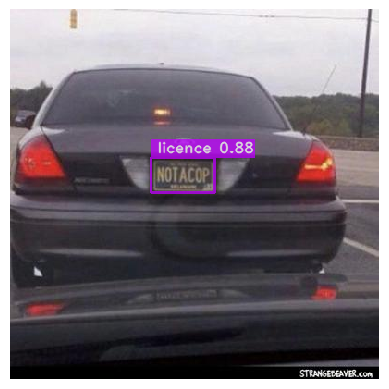

In [ ]:
img_url = '/content/drive/MyDrive/yolov8/test_images/Cars205_png.rf.4ec46820cc1dae0a9559fa87cc5d1d7d.jpg'
best_model.predict(img_url).show()

In [ ]:
input_video_path = f"/content/drive/MyDrive/yolov8/videos/test.mp4"
output_video_path = "detect2.mp4"

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [ ]:
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 628/628 [00:31<00:00, 19.90it/s]


In [ ]:
import shutil

# Replace 'file_name.ext' with the actual file name you want to copy
file_name = 'detect2.mp4'
source_path = '/content/' + file_name
destination_path = '/content/drive/MyDrive/nas/' + file_name

shutil.copyfile(source_path, destination_path)


'/content/drive/MyDrive/nas/detect2.mp4'